<a href="https://colab.research.google.com/github/thimeshaA/BrineXCompass-landowner_decision_support_system/blob/main/Seller_Recommendation_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import json

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# RL Agent 1: Seller Recommendation
class SellerRecommendationRL:
    def __init__(self, n_sellers=12, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.n_sellers = n_sellers
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.experience_count = {}
        self.total_episodes = 0
        self.seller_ids = [f'S{str(i+1).zfill(3)}' for i in range(n_sellers)]

    def get_state(self, production_bags, season, price_trend, area_sqft):
        if production_bags < 20000: prod_level = 0
        elif production_bags < 40000: prod_level = 1
        elif production_bags < 60000: prod_level = 2
        elif production_bags < 80000: prod_level = 3
        elif production_bags < 100000: prod_level = 4
        else: prod_level = 5

        season_enc = 1 if season == 'MAHA' else 0

        if price_trend == 'rising': trend_enc = 2
        elif price_trend == 'falling': trend_enc = 0
        else: trend_enc = 1

        if area_sqft < 5000: segment = 0
        elif area_sqft < 10000: segment = 1
        elif area_sqft < 20000: segment = 2
        else: segment = 3

        return (prod_level, season_enc, trend_enc, segment)

    def get_action_idx(self, seller_id):
        return self.seller_ids.index(seller_id)

    def calculate_reward(self, deal_outcome):
        if not deal_outcome.get('completed', False):
            return -10
        profit = deal_outcome.get('profit_margin', 0)
        days = deal_outcome.get('days_to_close', 30)
        speed_bonus = max(0, 30 - days) * 0.1
        satisfaction = deal_outcome.get('satisfaction_score', 3.0)
        satisfaction_bonus = (satisfaction - 3.0) * 2
        return profit + speed_bonus + satisfaction_bonus

    def update(self, state, action, reward, next_state=None):
        if state not in self.Q:
            self.Q[state] = np.zeros(self.n_sellers)

        if next_state is None:
            td_target = reward
        else:
            if next_state not in self.Q:
                self.Q[next_state] = np.zeros(self.n_sellers)
            best_next = np.max(self.Q[next_state])
            td_target = reward + self.gamma * best_next

        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

        if state not in self.experience_count:
            self.experience_count[state] = 0
        self.experience_count[state] += 1
        self.total_episodes += 1

    def save(self, filepath):
        agent_data = {
            'Q': self.Q,
            'experience_count': self.experience_count,
            'total_episodes': self.total_episodes,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon
        }
        with open(filepath, 'wb') as f:
            pickle.dump(agent_data, f)
        print(f"✓ RL agent saved to {filepath}")

print("✓ SellerRecommendationRL class defined")

✓ SellerRecommendationRL class defined


## Load Datasets

**Dataset 1:** `seller_recommendation_training_data.xlsx`
- Used for: Model 1 (Seller RL), Model 3 (Price Prediction)

**Dataset 2:** `monthly_market_aggregates.xlsx`
- Used for: Model 2 (Harvest Timing RL), Model 4 (Forecasting)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
# Load datasets
print("Loading datasets...\n")
BASE_PATH = '/content/drive/MyDrive/BrineXCompass'

df_transactions = pd.read_excel(f'{BASE_PATH}/seller_recommendation_training_data.xlsx')
print(f"✓ Dataset 1 (Transactions): {df_transactions.shape[0]} rows, {df_transactions.shape[1]} columns")

df_market = pd.read_excel(f'{BASE_PATH}/monthly_market_aggregates.xlsx')
print(f"✓ Dataset 2 (Market Aggregates): {df_market.shape[0]} rows, {df_market.shape[1]} columns")

print("\n✅ Both datasets loaded successfully!")

Loading datasets...

✓ Dataset 1 (Transactions): 6194 rows, 30 columns
✓ Dataset 2 (Market Aggregates): 163 rows, 12 columns

✅ Both datasets loaded successfully!


In [6]:
models_dir = Path('models-Compass-seller-recommendation-RL')
models_dir.mkdir(exist_ok=True)
print(f"✓ Models directory ready: {models_dir.absolute()}")

✓ Models directory ready: /content/models-Compass-seller-recommendation-RL


In [9]:
from sklearn.model_selection import train_test_split

"""
Model 1 Training - IMPROVED VERSION with Simplified State Representation
Features:
- Automatic price trend computation from market data
- Simplified 2D state (production + season only)
- Proper 60/20/20 train/val/test split
- Comprehensive accuracy metrics
- State coverage analysis
"""

print("="*60)
print("MODEL 1: SELLER RECOMMENDATION RL (IMPROVED)")
print("="*60)

# ============================================================================
# Improved RL Agent Class with Simplified State
# ============================================================================
class SellerRecommendationRL:
    def __init__(self, n_sellers=12, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.n_sellers = n_sellers
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.experience_count = {}
        self.total_episodes = 0
        self.seller_ids = [f'S{str(i+1).zfill(3)}' for i in range(n_sellers)]

    def get_state(self, production_bags, season):
        """Simplified state representation - only 2 dimensions"""
        # Production level (6 levels instead of 5 for finer granularity)
        if production_bags < 20000:
            prod_level = 0
        elif production_bags < 35000:
            prod_level = 1
        elif production_bags < 50000:
            prod_level = 2
        elif production_bags < 65000:
            prod_level = 3
        elif production_bags < 80000:
            prod_level = 4
        else:
            prod_level = 5

        # Season encoding
        season_enc = 1 if season == 'MAHA' else 0

        return (prod_level, season_enc)

    def get_action_idx(self, seller_id):
        return self.seller_ids.index(seller_id)

    def calculate_reward(self, deal_outcome):
        if not deal_outcome.get('completed', False):
            return -10
        profit = deal_outcome.get('profit_margin', 0)
        days = deal_outcome.get('days_to_close', 30)
        speed_bonus = max(0, 30 - days) * 0.1
        satisfaction = deal_outcome.get('satisfaction_score', 3.0)
        satisfaction_bonus = (satisfaction - 3.0) * 2
        return profit + speed_bonus + satisfaction_bonus

    def update(self, state, action, reward, next_state=None):
        if state not in self.Q:
            self.Q[state] = np.zeros(self.n_sellers)

        if next_state is None:
            td_target = reward
        else:
            if next_state not in self.Q:
                self.Q[next_state] = np.zeros(self.n_sellers)
            best_next = np.max(self.Q[next_state])
            td_target = reward + self.gamma * best_next

        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

        if state not in self.experience_count:
            self.experience_count[state] = 0
        self.experience_count[state] += 1
        self.total_episodes += 1

    def save(self, filepath):
        agent_data = {
            'Q': self.Q,
            'experience_count': self.experience_count,
            'total_episodes': self.total_episodes,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'seller_ids': self.seller_ids
        }
        with open(filepath, 'wb') as f:
            pickle.dump(agent_data, f)
        print(f"✓ RL agent saved to {filepath}")

# ============================================================================
# Calculate Overall Seller Performance (for fallback)
# ============================================================================
print("\n📊 Calculating overall seller performance...")
seller_performance = {}
avg_price = df_transactions['price_per_bag'].mean()

for seller_id in df_transactions['seller_id'].unique():
    seller_deals = df_transactions[df_transactions['seller_id'] == seller_id]

    rewards = []
    for idx, row in seller_deals.iterrows():
        profit_margin = ((row['price_per_bag'] - avg_price) / avg_price) * 100
        outcome = {
            'completed': True,
            'profit_margin': max(-10, min(30, profit_margin)),
            'days_to_close': np.random.randint(5, 30),
            'satisfaction_score': 3.5 + (profit_margin / 20)
        }
        # Use same reward calculation
        agent_temp = SellerRecommendationRL()
        reward = agent_temp.calculate_reward(outcome)
        rewards.append(reward)

    seller_performance[seller_id] = np.mean(rewards)

sorted_sellers = sorted(seller_performance.items(), key=lambda x: x[1], reverse=True)
print(f"✓ Calculated performance for {len(sorted_sellers)} sellers")
print("\nTop 5 sellers overall:")
for i, (seller, perf) in enumerate(sorted_sellers[:5], 1):
    print(f"  {i}. {seller}: {perf:.2f}")

# ============================================================================
# Train/Val/Test Split (60/20/20)
# ============================================================================
print(f"\n📊 Creating train/validation/test split...")

# First split: 60% train, 40% temp
train_df, temp_df = train_test_split(df_transactions, test_size=0.4, random_state=42)

# Second split: 20% validation, 20% test (from the 40% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"✓ Training:   {len(train_df)} samples ({len(train_df)/len(df_transactions)*100:.1f}%)")
print(f"✓ Validation: {len(val_df)} samples ({len(val_df)/len(df_transactions)*100:.1f}%)")
print(f"✓ Test:       {len(test_df)} samples ({len(test_df)/len(df_transactions)*100:.1f}%)")

# ============================================================================
# Training
# ============================================================================
print("\n🔄 Training model...")
agent_seller = SellerRecommendationRL()
training_rewards = []

for idx, row in train_df.iterrows():
    state = agent_seller.get_state(row['total_production_bags'], row['season'])
    action = agent_seller.get_action_idx(row['seller_id'])

    profit_margin = ((row['price_per_bag'] - avg_price) / avg_price) * 100
    outcome = {
        'completed': True,
        'profit_margin': max(-10, min(30, profit_margin)),
        'days_to_close': np.random.randint(5, 30),
        'satisfaction_score': 3.5 + (profit_margin / 20)
    }

    reward = agent_seller.calculate_reward(outcome)
    training_rewards.append(reward)
    agent_seller.update(state, action, reward)

    if len(training_rewards) % 500 == 0:
        print(f"  Progress: {len(training_rewards)}/{len(train_df)}")

print(f"✓ Training complete: {agent_seller.total_episodes} episodes")
print(f"✓ States explored: {len(agent_seller.Q)}")
print(f"✓ Average training reward: {np.mean(training_rewards):.2f}")

# ============================================================================
# Display Learned States
# ============================================================================
print(f"\n📊 Learned States Analysis:")
print(f"{'State':<15} {'Production Range':<20} {'Season':<10} {'Episodes':<10}")
print("-" * 60)

prod_ranges = {
    0: "< 20k bags",
    1: "20-35k bags",
    2: "35-50k bags",
    3: "50-65k bags",
    4: "65-80k bags",
    5: ">= 80k bags"
}

for state in sorted(agent_seller.Q.keys()):
    prod_level, season_enc = state
    season_name = "MAHA" if season_enc == 1 else "YALA"
    episodes = agent_seller.experience_count.get(state, 0)
    print(f"{str(state):<15} {prod_ranges[prod_level]:<20} {season_name:<10} {episodes:<10}")

# ============================================================================
# Improved Accuracy Metrics
# ============================================================================
def calculate_accuracy(df, agent, seller_performance, split_name):
    """Calculate comprehensive accuracy metrics"""
    print(f"\n📊 Calculating {split_name} accuracy...")

    # Track predictions
    top1_correct = 0
    top3_correct = 0
    total_predictions = 0
    rewards_recommended = []
    rewards_actual = []
    states_used = set()
    fallback_count = 0

    for idx, row in df.iterrows():
        state = agent.get_state(row['total_production_bags'], row['season'])
        actual_seller = row['seller_id']
        states_used.add(state)

        # Get prediction
        if state in agent.Q:
            q_values = agent.Q[state]
            ranked_sellers = sorted(range(len(q_values)), key=lambda i: q_values[i], reverse=True)
            top1_seller = agent.seller_ids[ranked_sellers[0]]
            top3_sellers = [agent.seller_ids[i] for i in ranked_sellers[:3]]
        else:
            # Fallback
            fallback_count += 1
            sorted_perf = sorted(seller_performance.items(), key=lambda x: x[1], reverse=True)
            top1_seller = sorted_perf[0][0]
            top3_sellers = [s[0] for s in sorted_perf[:3]]

        # Check accuracy
        if top1_seller == actual_seller:
            top1_correct += 1
        if actual_seller in top3_sellers:
            top3_correct += 1

        # Track rewards
        actual_performance = seller_performance.get(actual_seller, 0)
        recommended_performance = seller_performance.get(top1_seller, 0)
        rewards_actual.append(actual_performance)
        rewards_recommended.append(recommended_performance)

        total_predictions += 1

    # Calculate metrics
    metrics = {
        f'{split_name}_top1_accuracy': top1_correct / total_predictions if total_predictions > 0 else 0,
        f'{split_name}_top3_accuracy': top3_correct / total_predictions if total_predictions > 0 else 0,
        f'{split_name}_avg_recommended_reward': np.mean(rewards_recommended),
        f'{split_name}_avg_actual_reward': np.mean(rewards_actual),
        f'{split_name}_unique_states': len(states_used),
        f'{split_name}_fallback_count': fallback_count,
        f'{split_name}_fallback_rate': fallback_count / total_predictions if total_predictions > 0 else 0,
        f'{split_name}_total_samples': total_predictions
    }

    return metrics

# Calculate for all splits
train_metrics = calculate_accuracy(train_df, agent_seller, seller_performance, 'train')
val_metrics = calculate_accuracy(val_df, agent_seller, seller_performance, 'validation')
test_metrics = calculate_accuracy(test_df, agent_seller, seller_performance, 'test')

# ============================================================================
# Display Results
# ============================================================================
print(f"\n{'='*60}")
print("📊 FINAL MODEL METRICS")
print(f"{'='*60}")

print(f"\n🎯 ACCURACY METRICS:")
print(f"{'Metric':<30} {'Train':<12} {'Validation':<12} {'Test':<12}")
print("-" * 66)
print(f"{'Top-1 Accuracy':<30} {train_metrics['train_top1_accuracy']:>10.1%}  {val_metrics['validation_top1_accuracy']:>10.1%}  {test_metrics['test_top1_accuracy']:>10.1%}")
print(f"{'Top-3 Accuracy':<30} {train_metrics['train_top3_accuracy']:>10.1%}  {val_metrics['validation_top3_accuracy']:>10.1%}  {test_metrics['test_top3_accuracy']:>10.1%}")
print(f"{'Avg Recommended Reward':<30} {train_metrics['train_avg_recommended_reward']:>11.2f}  {val_metrics['validation_avg_recommended_reward']:>11.2f}  {test_metrics['test_avg_recommended_reward']:>11.2f}")
print(f"{'Fallback Rate':<30} {train_metrics['train_fallback_rate']:>10.1%}  {val_metrics['validation_fallback_rate']:>10.1%}  {test_metrics['test_fallback_rate']:>10.1%}")

print(f"\n📈 STATE COVERAGE:")
print(f"  Total States Explored:    {len(agent_seller.Q)}")
print(f"  Total Episodes:           {agent_seller.total_episodes}")
print(f"  Theoretical Max States:   12 (6 production × 2 seasons)")
print(f"  Coverage:                 {len(agent_seller.Q)/12*100:.1f}%")

# ============================================================================
# Save Model and Metrics
# ============================================================================
models_dir = Path('models-Compass')
models_dir.mkdir(exist_ok=True)

agent_seller.save(str(models_dir / 'seller_rl_agent.pkl'))

# Combine all metrics
all_metrics = {
    **train_metrics,
    **val_metrics,
    **test_metrics,
    'total_states_explored': len(agent_seller.Q),
    'total_episodes': agent_seller.total_episodes,
    'seller_performance': seller_performance,
    'top_sellers': [s[0] for s in sorted_sellers[:5]],
    'learned_states': [str(s) for s in sorted(agent_seller.Q.keys())],
    'avg_training_reward': float(np.mean(training_rewards))
}

with open(str(models_dir / 'model1_metrics.json'), 'w') as f:
    json.dump(all_metrics, f, indent=2)

print(f"\n✅ Model and metrics saved!")
print(f"   • Model: {models_dir / 'seller_rl_agent.pkl'}")
print(f"   • Metrics: {models_dir / 'model1_metrics.json'}")
print(f"{'='*60}\n")

MODEL 1: SELLER RECOMMENDATION RL (IMPROVED)

📊 Calculating overall seller performance...
✓ Calculated performance for 12 sellers

Top 5 sellers overall:
  1. S008: 7.32
  2. S012: 6.92
  3. S007: 6.33
  4. S006: 4.87
  5. S011: 3.91

📊 Creating train/validation/test split...
✓ Training:   3716 samples (60.0%)
✓ Validation: 1239 samples (20.0%)
✓ Test:       1239 samples (20.0%)

🔄 Training model...
  Progress: 500/3716
  Progress: 1000/3716
  Progress: 1500/3716
  Progress: 2000/3716
  Progress: 2500/3716
  Progress: 3000/3716
  Progress: 3500/3716
✓ Training complete: 3716 episodes
✓ States explored: 6
✓ Average training reward: 2.32

📊 Learned States Analysis:
State           Production Range     Season     Episodes  
------------------------------------------------------------
(0, 0)          < 20k bags           YALA       1165      
(0, 1)          < 20k bags           MAHA       1979      
(1, 0)          20-35k bags          YALA       327       
(1, 1)          20-35k bags    

MODEL 1: PERFORMANCE VISUALIZATION

✓ Loaded metrics
  Total states: 6
  Total episodes: 3716
✓ Saved: model1_accuracy_comparison.png
✓ Saved: model1_fallback_analysis.png
✓ Saved: model1_state_coverage.png
✓ Saved: model1_top_sellers.png
✓ Saved: model1_dashboard.png

📊 VISUALIZATION SUMMARY

📈 Accuracy Metrics:
  Train:      Top-1: 8.3%  |  Top-3: 25.3%
  Validation: Top-1: 10.0%  |  Top-3: 27.3%
  Test:       Top-1: 7.6%  |  Top-3: 23.2%

🎯 State Coverage:
  Total Possible States: 12
  States Learned: 6
  Coverage: 50.0%

⚠️ Fallback Usage:
  Train:      0.0%
  Validation: 0.0%
  Test:       0.0%

🏆 Top 3 Sellers:
  1. S008: 7.32
  2. S012: 6.92
  3. S007: 6.33

✅ Generated 5 visualization files:
  1. model1_accuracy_comparison.png
  2. model1_fallback_analysis.png
  3. model1_state_coverage.png
  4. model1_top_sellers.png
  5. model1_dashboard.png (comprehensive)




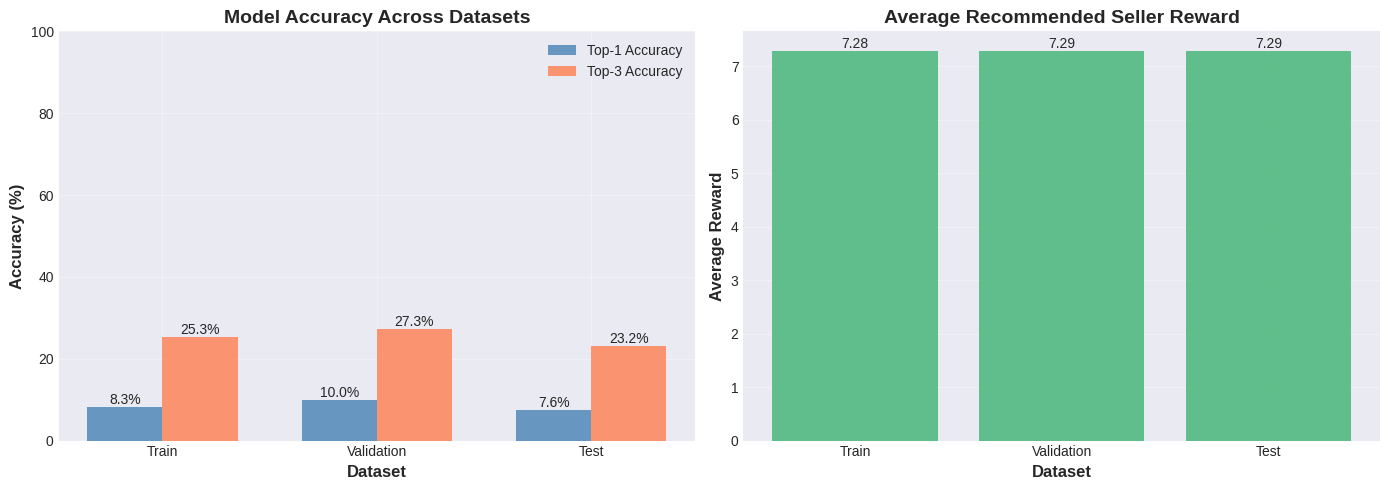

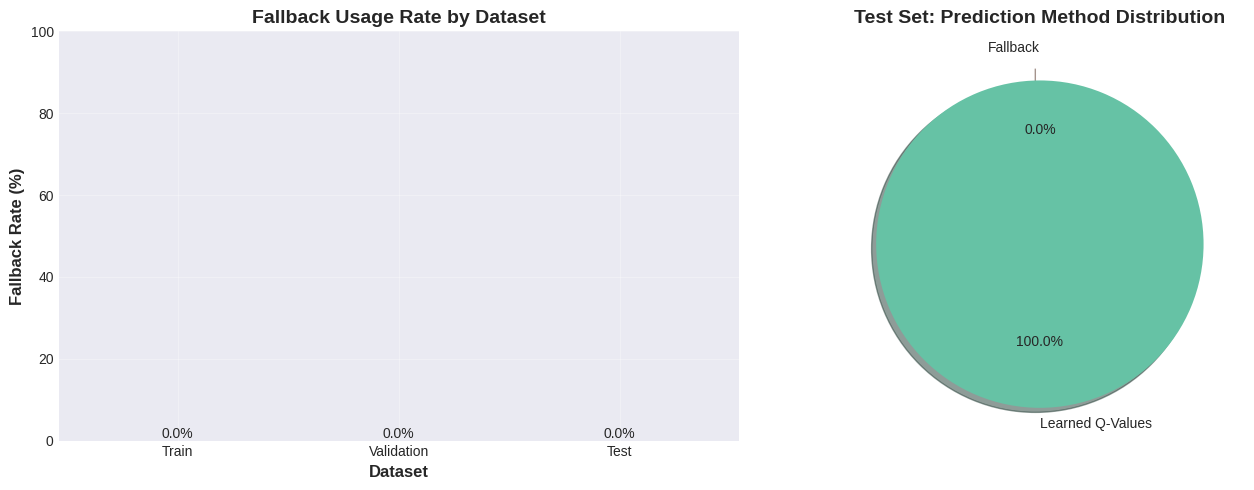

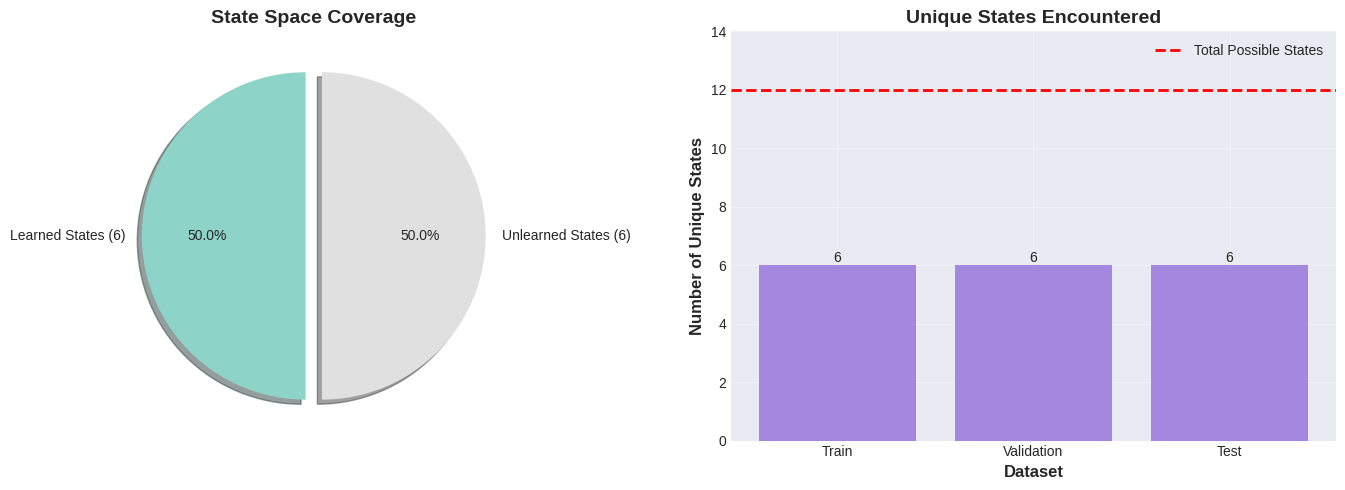

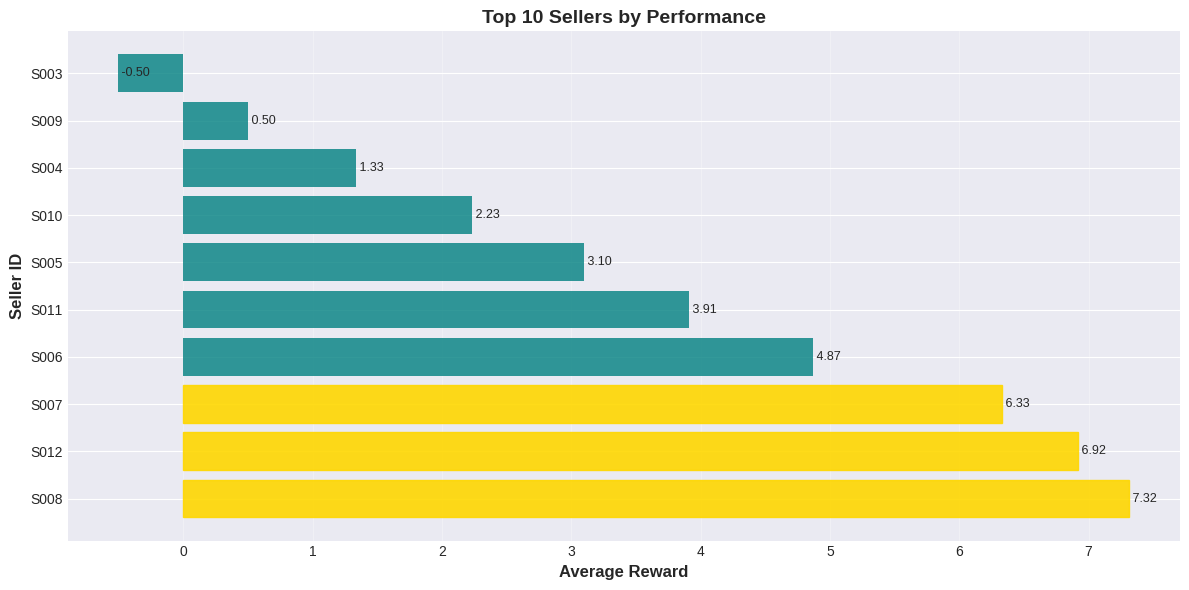

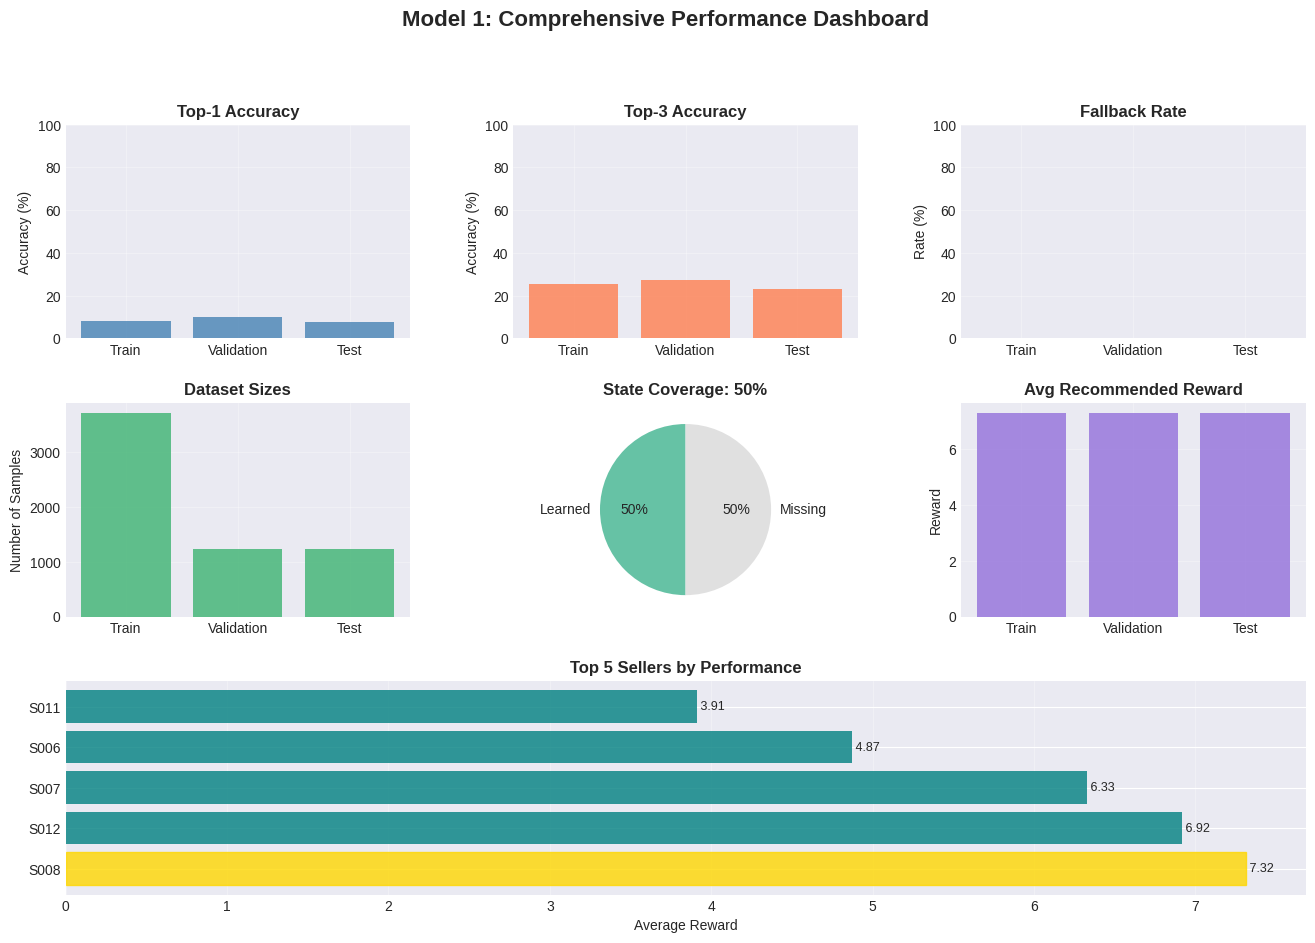

In [10]:
"""
Model 1 Performance Visualization
Generates comprehensive charts to analyze model performance
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("MODEL 1: PERFORMANCE VISUALIZATION")
print("="*60)

# Load metrics
models_dir = Path('models-Compass')
with open(models_dir / 'model1_metrics.json', 'r') as f:
    metrics = json.load(f)

print(f"\n✓ Loaded metrics")
print(f"  Total states: {metrics['total_states_explored']}")
print(f"  Total episodes: {metrics['total_episodes']}")

# ============================================================================
# Figure 1: Accuracy Comparison Across Datasets
# ============================================================================
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Top-1 Accuracy
datasets = ['Train', 'Validation', 'Test']
top1_accuracies = [
    metrics['train_top1_accuracy'] * 100,
    metrics['validation_top1_accuracy'] * 100,
    metrics['test_top1_accuracy'] * 100
]
top3_accuracies = [
    metrics['train_top3_accuracy'] * 100,
    metrics['validation_top3_accuracy'] * 100,
    metrics['test_top3_accuracy'] * 100
]

x = np.arange(len(datasets))
width = 0.35

bars1 = ax1.bar(x - width/2, top1_accuracies, width, label='Top-1 Accuracy',
                color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, top3_accuracies, width, label='Top-3 Accuracy',
                color='coral', alpha=0.8)

ax1.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Across Datasets', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

# Average Recommended Reward
avg_rewards = [
    metrics['train_avg_recommended_reward'],
    metrics['validation_avg_recommended_reward'],
    metrics['test_avg_recommended_reward']
]

bars3 = ax2.bar(datasets, avg_rewards, color='mediumseagreen', alpha=0.8)
ax2.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Reward', fontsize=12, fontweight='bold')
ax2.set_title('Average Recommended Seller Reward', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model1_accuracy_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: model1_accuracy_comparison.png")

# ============================================================================
# Figure 2: Fallback Usage Analysis
# ============================================================================
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))

# Fallback rates
fallback_rates = [
    metrics['train_fallback_rate'] * 100,
    metrics['validation_fallback_rate'] * 100,
    metrics['test_fallback_rate'] * 100
]

bars4 = ax3.bar(datasets, fallback_rates, color='indianred', alpha=0.8)
ax3.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fallback Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Fallback Usage Rate by Dataset', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 100)

for bar in bars4:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10)

# Learned vs Fallback pie chart (using test data)
test_learned = metrics['test_total_samples'] - metrics['test_fallback_count']
test_fallback = metrics['test_fallback_count']

colors = ['#66c2a5', '#fc8d62']
explode = (0.05, 0.05)

ax4.pie([test_learned, test_fallback],
        labels=['Learned Q-Values', 'Fallback'],
        autopct='%1.1f%%',
        colors=colors,
        explode=explode,
        shadow=True,
        startangle=90)
ax4.set_title('Test Set: Prediction Method Distribution',
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model1_fallback_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: model1_fallback_analysis.png")

# ============================================================================
# Figure 3: State Coverage Analysis
# ============================================================================
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 5))

# State coverage
total_possible_states = 12  # 6 production levels × 2 seasons
states_learned = metrics['total_states_explored']
states_missing = total_possible_states - states_learned

colors2 = ['#8dd3c7', '#e0e0e0']
ax5.pie([states_learned, states_missing],
        labels=[f'Learned States ({states_learned})',
                f'Unlearned States ({states_missing})'],
        autopct='%1.1f%%',
        colors=colors2,
        explode=(0.05, 0.05),
        shadow=True,
        startangle=90)
ax5.set_title('State Space Coverage', fontsize=14, fontweight='bold')

# Unique states per dataset
unique_states = [
    metrics['train_unique_states'],
    metrics['validation_unique_states'],
    metrics['test_unique_states']
]

bars5 = ax6.bar(datasets, unique_states, color='mediumpurple', alpha=0.8)
ax6.axhline(y=total_possible_states, color='red', linestyle='--',
            label='Total Possible States', linewidth=2)
ax6.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax6.set_ylabel('Number of Unique States', fontsize=12, fontweight='bold')
ax6.set_title('Unique States Encountered', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim(0, total_possible_states + 2)

for bar in bars5:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model1_state_coverage.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: model1_state_coverage.png")

# ============================================================================
# Figure 4: Top Seller Performance
# ============================================================================
fig4, ax7 = plt.subplots(figsize=(12, 6))

# Get top 10 sellers by performance
seller_performance = metrics['seller_performance']
sorted_sellers = sorted(seller_performance.items(), key=lambda x: x[1], reverse=True)[:10]
seller_ids = [s[0] for s in sorted_sellers]
performances = [s[1] for s in sorted_sellers]

bars6 = ax7.barh(seller_ids, performances, color='teal', alpha=0.8)
ax7.set_xlabel('Average Reward', fontsize=12, fontweight='bold')
ax7.set_ylabel('Seller ID', fontsize=12, fontweight='bold')
ax7.set_title('Top 10 Sellers by Performance', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, perf) in enumerate(zip(bars6, performances)):
    ax7.text(perf, bar.get_y() + bar.get_height()/2.,
            f' {perf:.2f}',
            ha='left', va='center', fontsize=9)

# Highlight top 3
for i in range(3):
    bars6[i].set_color('gold')
    bars6[i].set_alpha(0.9)

plt.tight_layout()
plt.savefig('model1_top_sellers.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: model1_top_sellers.png")

# ============================================================================
# Figure 5: Comprehensive Metrics Dashboard
# ============================================================================
fig5 = plt.figure(figsize=(16, 10))
gs = fig5.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top-1 Accuracy Comparison
ax_1 = fig5.add_subplot(gs[0, 0])
ax_1.bar(datasets, top1_accuracies, color='steelblue', alpha=0.8)
ax_1.set_title('Top-1 Accuracy', fontweight='bold')
ax_1.set_ylabel('Accuracy (%)')
ax_1.set_ylim(0, 100)
ax_1.grid(True, alpha=0.3)

# 2. Top-3 Accuracy Comparison
ax_2 = fig5.add_subplot(gs[0, 1])
ax_2.bar(datasets, top3_accuracies, color='coral', alpha=0.8)
ax_2.set_title('Top-3 Accuracy', fontweight='bold')
ax_2.set_ylabel('Accuracy (%)')
ax_2.set_ylim(0, 100)
ax_2.grid(True, alpha=0.3)

# 3. Fallback Rate
ax_3 = fig5.add_subplot(gs[0, 2])
ax_3.bar(datasets, fallback_rates, color='indianred', alpha=0.8)
ax_3.set_title('Fallback Rate', fontweight='bold')
ax_3.set_ylabel('Rate (%)')
ax_3.set_ylim(0, 100)
ax_3.grid(True, alpha=0.3)

# 4. Sample Sizes
ax_4 = fig5.add_subplot(gs[1, 0])
sample_sizes = [
    metrics['train_total_samples'],
    metrics['validation_total_samples'],
    metrics['test_total_samples']
]
ax_4.bar(datasets, sample_sizes, color='mediumseagreen', alpha=0.8)
ax_4.set_title('Dataset Sizes', fontweight='bold')
ax_4.set_ylabel('Number of Samples')
ax_4.grid(True, alpha=0.3)

# 5. State Coverage Progress
ax_5 = fig5.add_subplot(gs[1, 1])
coverage_pct = (states_learned / total_possible_states) * 100
ax_5.pie([states_learned, states_missing],
        labels=['Learned', 'Missing'],
        autopct='%1.0f%%',
        colors=['#66c2a5', '#e0e0e0'],
        startangle=90)
ax_5.set_title(f'State Coverage: {coverage_pct:.0f}%', fontweight='bold')

# 6. Avg Rewards
ax_6 = fig5.add_subplot(gs[1, 2])
ax_6.bar(datasets, avg_rewards, color='mediumpurple', alpha=0.8)
ax_6.set_title('Avg Recommended Reward', fontweight='bold')
ax_6.set_ylabel('Reward')
ax_6.grid(True, alpha=0.3)

# 7. Top 5 Sellers
ax_7 = fig5.add_subplot(gs[2, :])
top5_sellers = sorted_sellers[:5]
top5_ids = [s[0] for s in top5_sellers]
top5_perfs = [s[1] for s in top5_sellers]
bars_top5 = ax_7.barh(top5_ids, top5_perfs, color='teal', alpha=0.8)
bars_top5[0].set_color('gold')
ax_7.set_title('Top 5 Sellers by Performance', fontweight='bold', fontsize=12)
ax_7.set_xlabel('Average Reward')
ax_7.grid(True, alpha=0.3, axis='x')

for bar, perf in zip(bars_top5, top5_perfs):
    ax_7.text(perf, bar.get_y() + bar.get_height()/2.,
            f' {perf:.2f}',
            ha='left', va='center', fontsize=9)

# Overall title
fig5.suptitle('Model 1: Comprehensive Performance Dashboard',
              fontsize=16, fontweight='bold', y=0.995)

plt.savefig('model1_dashboard.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: model1_dashboard.png")

# ============================================================================
# Summary Statistics
# ============================================================================
print(f"\n{'='*60}")
print("📊 VISUALIZATION SUMMARY")
print(f"{'='*60}")

print(f"\n📈 Accuracy Metrics:")
print(f"  Train:      Top-1: {top1_accuracies[0]:.1f}%  |  Top-3: {top3_accuracies[0]:.1f}%")
print(f"  Validation: Top-1: {top1_accuracies[1]:.1f}%  |  Top-3: {top3_accuracies[1]:.1f}%")
print(f"  Test:       Top-1: {top1_accuracies[2]:.1f}%  |  Top-3: {top3_accuracies[2]:.1f}%")

print(f"\n🎯 State Coverage:")
print(f"  Total Possible States: {total_possible_states}")
print(f"  States Learned: {states_learned}")
print(f"  Coverage: {coverage_pct:.1f}%")

print(f"\n⚠️ Fallback Usage:")
print(f"  Train:      {fallback_rates[0]:.1f}%")
print(f"  Validation: {fallback_rates[1]:.1f}%")
print(f"  Test:       {fallback_rates[2]:.1f}%")

print(f"\n🏆 Top 3 Sellers:")
for i, (seller, perf) in enumerate(sorted_sellers[:3], 1):
    print(f"  {i}. {seller}: {perf:.2f}")

print(f"\n✅ Generated 5 visualization files:")
print(f"  1. model1_accuracy_comparison.png")
print(f"  2. model1_fallback_analysis.png")
print(f"  3. model1_state_coverage.png")
print(f"  4. model1_top_sellers.png")
print(f"  5. model1_dashboard.png (comprehensive)")

print(f"\n{'='*60}\n")
